In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
class bcolors:
    """Coloring for print statements in terminal/logs"""
    ENDC = "\033[0m"
    BOLD = "\033[1m"
    UNDERLINE = "\033[4m"

    HEADER = "\033[95m"
    OKBLUE = "\033[94m"
    OKCYAN = "\033[96m"
    OKGREEN = "\033[92m"
    WARNING = "\033[93m"
    FAIL = "\033[91m"

In [3]:
# Visualize the speed distribution
metrics_df = pd.read_csv("Speed_Test_Interview_Project_Metrics_Table_v2.csv")
metrics_df.head()

/var/folders/nh/m91qpv214t9b8xssz75rnw580000gn/T/ipykernel_2796/923163011.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  metrics_df = pd.read_csv("Speed_Test_Interview_Project_Metrics_Table_v2.csv")


,router_speedtest_tcp_64_download_Mbps_avg,slot_timestamp,ut_ping_loss_rate,cell_id,home_pop_id,gateway_id,satellite_id,ut_snr,expected_min_snr,ut_latency,link_failure_detected,ut_sat_elevation_angle_mean,number_of_ku_beam_targets,number_of_users_on_ku_beam,number_of_users_on_ku_beam_target,ku_beam_target_cell_id,local_hour,country_code,test_id
0,278.145844,2021-12-21T15:26:12Z,0.000000,1050959,12,10158,1288,8.468927,5.640497,62.020656,False,0.446739,1,5,5,1050645,23,AU,1
1,174.016281,2021-12-21T15:06:42Z,0.117603,1051272,13,10053,1238,8.707482,5.358471,81.091325,False,0.543679,1,31,31,1051588,23,AU,2
2,249.541458,2021-12-21T15:05:57Z,0.038403,1050955,12,10158,2485,8.867315,6.762557,94.460829,False,0.446760,1,59,59,1050956,23,AU,3
3,222.936905,2021-12-21T14:08:42Z,0.000000,1050962,12,10053,1762,9.449574,6.403923,71.237235,False,0.486477,1,3,3,1050648,22,AU,4
4,106.995003,2021-12-21T13:58:27Z,0.000000,835617,13,10375,2474,7.331825,5.267703,36.324433,False,0.696587,2,71,49,835617,23,AU,5


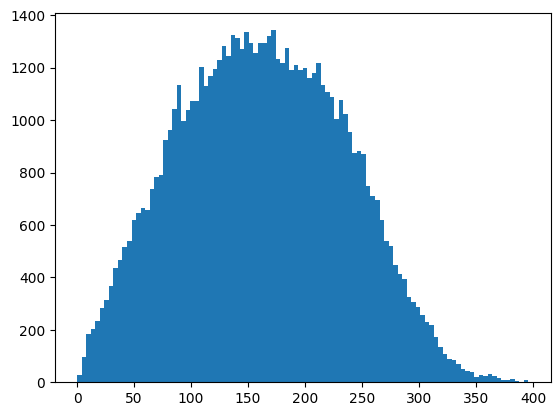

Number of unique slot_timestamps: 26663


In [4]:
plt.hist(metrics_df['router_speedtest_tcp_64_download_Mbps_avg'], bins=100)
plt.show()
print(f"Number of unique slot_timestamps: {metrics_df['slot_timestamp'].nunique()}")

In [5]:
print("Check NaNs...")
metrics_df.isna().sum().sort_values(ascending=False)

Check NaNs...


link_failure_detected                        44153
ut_ping_loss_rate                              164
router_speedtest_tcp_64_download_Mbps_avg        0
country_code                                     0
local_hour                                       0
ku_beam_target_cell_id                           0
number_of_users_on_ku_beam_target                0
number_of_users_on_ku_beam                       0
number_of_ku_beam_targets                        0
ut_sat_elevation_angle_mean                      0
ut_latency                                       0
slot_timestamp                                   0
expected_min_snr                                 0
ut_snr                                           0
satellite_id                                     0
gateway_id                                       0
home_pop_id                                      0
cell_id                                          0
test_id                                          0
dtype: int64

# EDA - Covariate Shift Analysis

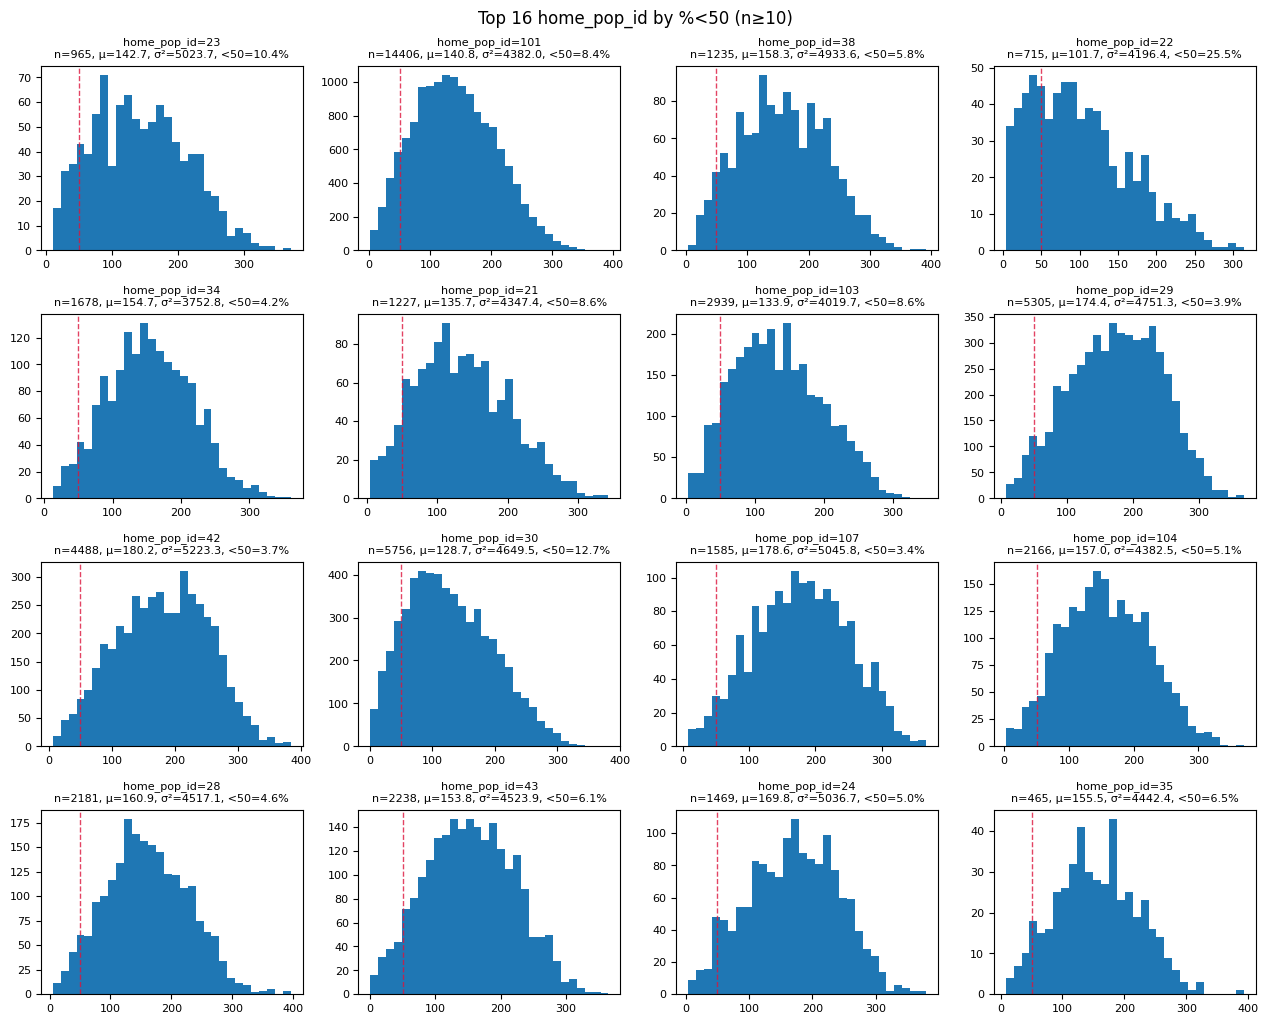

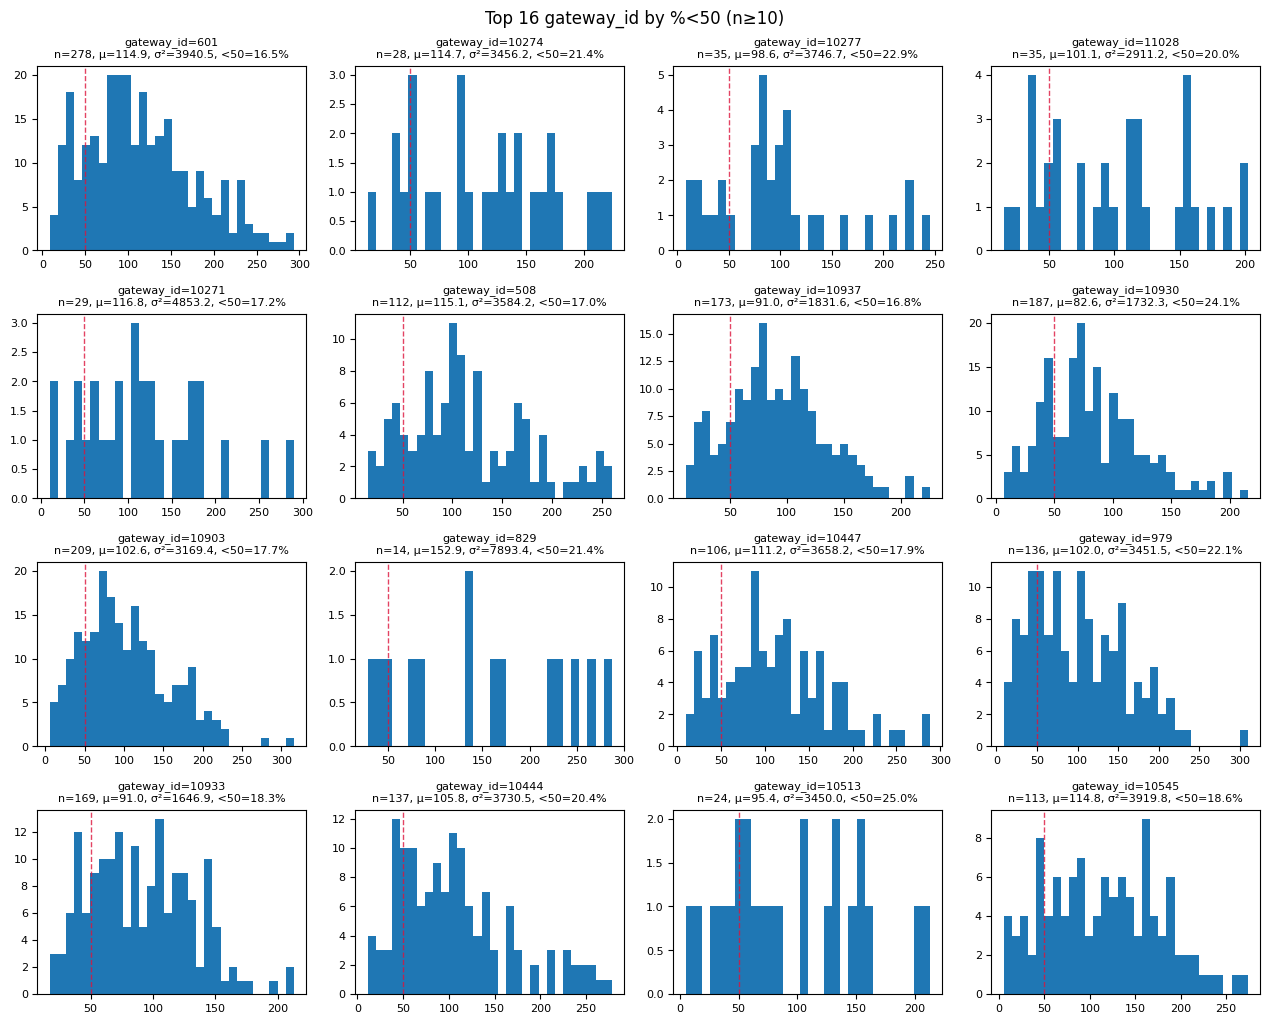

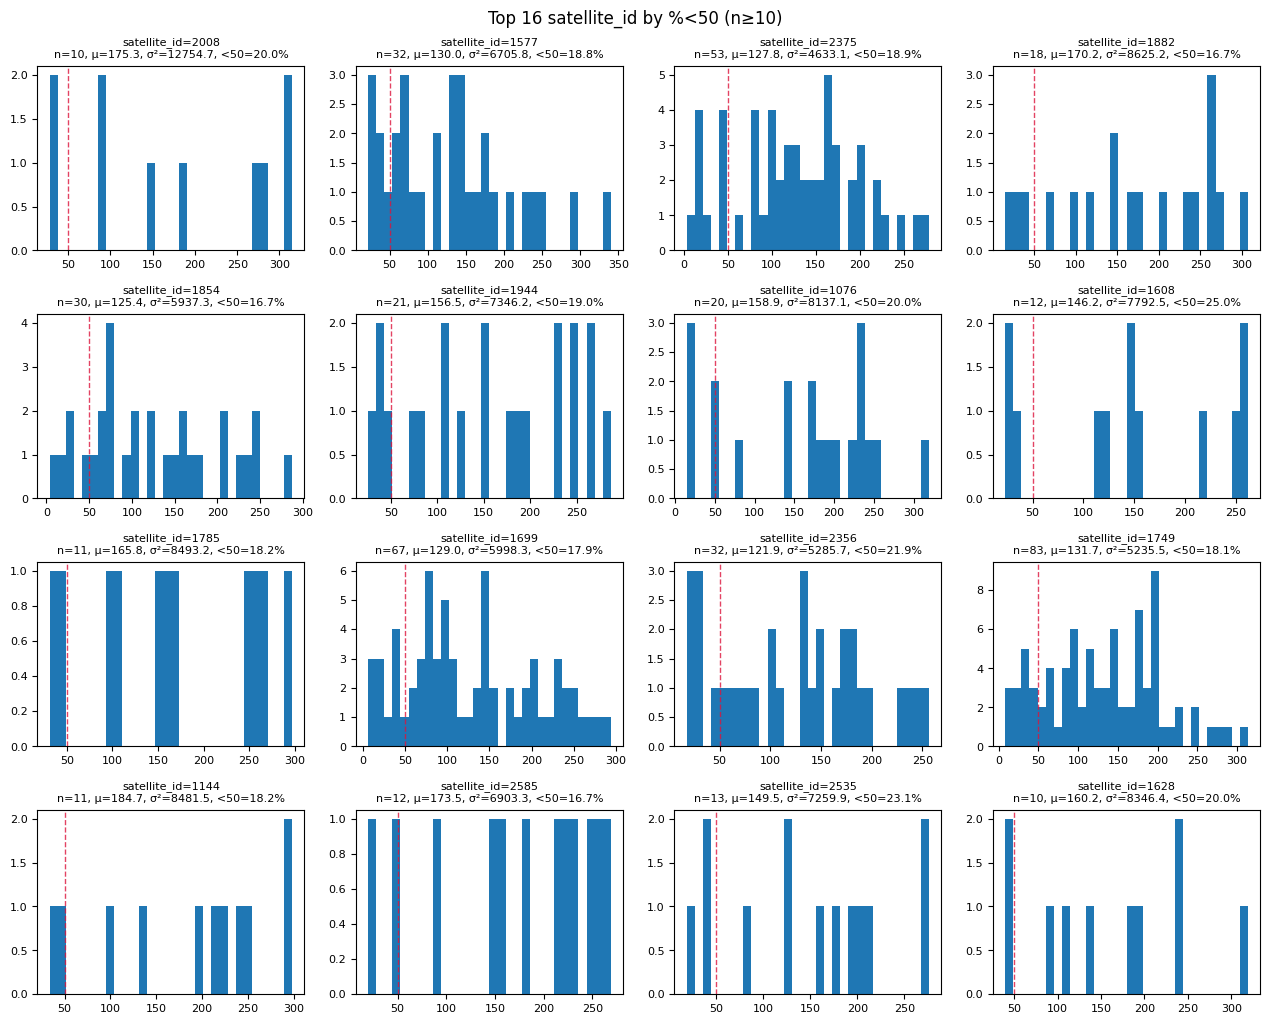

In [7]:
"""

    EDA on physical infrastructure of 
    the Starlink network

    Evaluating the actual PoPs, Gateways, and Satellites
    to see if any are associated with particularly slow speeds
    (potentially indicating congestion or other issues)

"""

scol = 'router_speedtest_tcp_64_download_Mbps_avg'
indices = ['home_pop_id', 'gateway_id', 'satellite_id']
top_k = 16
min_n = 10
bins = 30


def plot_slowest_hists_by_index(df, index_col, scol, top_k=8, min_n=10, bins=30, threshold=50):
    sub = df[[index_col, scol]].dropna()

    # Compute per-group stats, including share below threshold
    grp_counts_means = sub.groupby(index_col)[scol].agg(n='count', mu='mean')
    share_below = sub.assign(_lt=(sub[scol] < threshold)).groupby(index_col)['_lt'].mean().rename('p_lt')
    stats = grp_counts_means.join(share_below)

    # Select top groups by highest percent below threshold (edge-case slow). 
    # This metric is used because it normalizes the comparison between different groups (PoPs, Gateways, Satellites) against the quantity
    # of speed tests that run on each piece of infrastructure.
    eligible = stats[stats['n'] >= min_n]
    if eligible.empty:
        print(f'No groups in {index_col} with ≥ {min_n} samples.')
        return
    slow_ids = eligible.sort_values(['p_lt', 'mu'], ascending=[False, True]).head(top_k).index

    sub = sub[sub[index_col].isin(slow_ids)].copy()
    sub[index_col] = sub[index_col].astype(str)

    groups = [g for _, g in sub.groupby(index_col, sort=False)]
    n = len(groups)
    cols = min(4, n)
    rows = (n + cols - 1) // cols

    fig, axs = plt.subplots(rows, cols, figsize=(3.2*cols, 2.6*rows))
    axs = np.atleast_1d(axs).ravel()

    for ax, g in zip(axs, groups):
        s = g[scol].values
        m = float(np.mean(s))
        v = float(np.var(s, ddof=1)) if len(s) > 1 else 0.0
        pct_lt = 100.0 * float((s < threshold).mean()) if len(s) > 0 else 0.0

        ax.hist(s, bins=bins, color='C0')
        ax.axvline(threshold, color='crimson', linestyle='--', linewidth=1, alpha=0.8)

        label = g[index_col].iloc[0]
        ax.set_title(f'{index_col}={label}\nn={len(s)}, μ={m:.1f}, σ²={v:.1f}, <{threshold}={pct_lt:.1f}%', fontsize=8)
        ax.tick_params(labelsize=8)

    for ax in axs[n:]:
        ax.axis('off')

    fig.suptitle(f'Top {top_k} {index_col} by %<{threshold} (n≥{min_n})', fontsize=12, y=0.98)
    plt.tight_layout()
    plt.show()

for idx in indices:
    plot_slowest_hists_by_index(metrics_df, idx, scol, top_k=top_k, min_n=min_n, bins=bins)

## Better idea:

look for covariate shift between records that are slow and nonslow records

In [8]:
slow_records = metrics_df[metrics_df['router_speedtest_tcp_64_download_Mbps_avg'] < 50]
nonslow_records = metrics_df[metrics_df['router_speedtest_tcp_64_download_Mbps_avg'] >= 50]

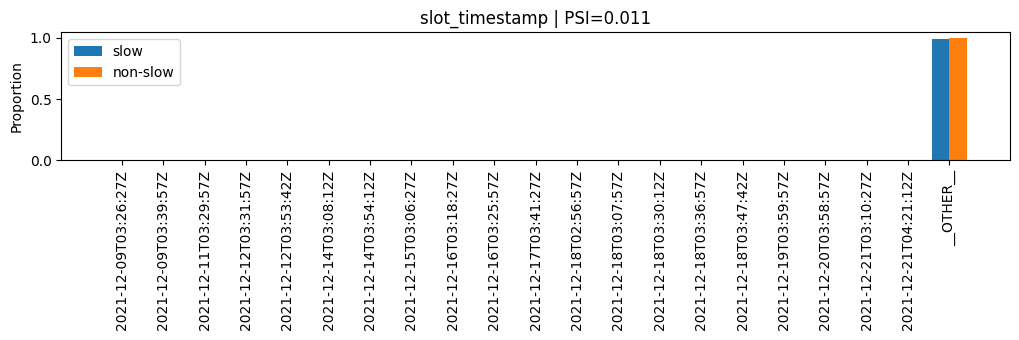

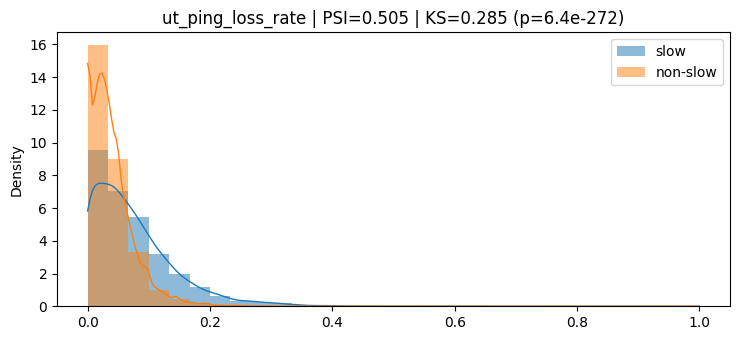

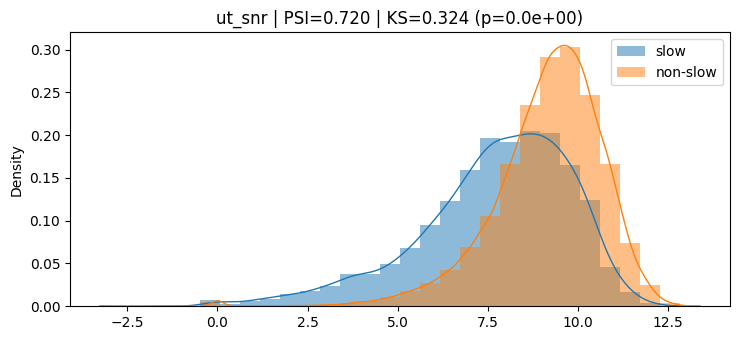

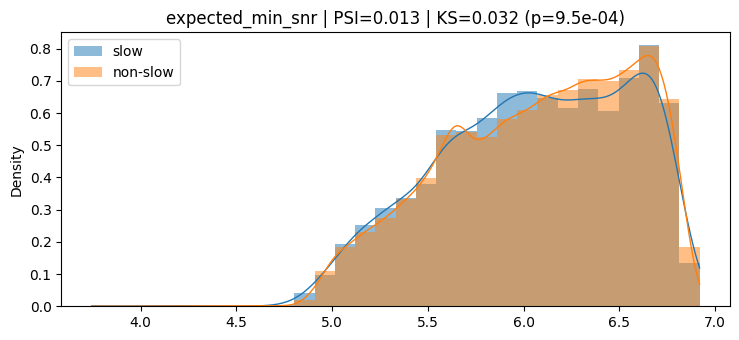

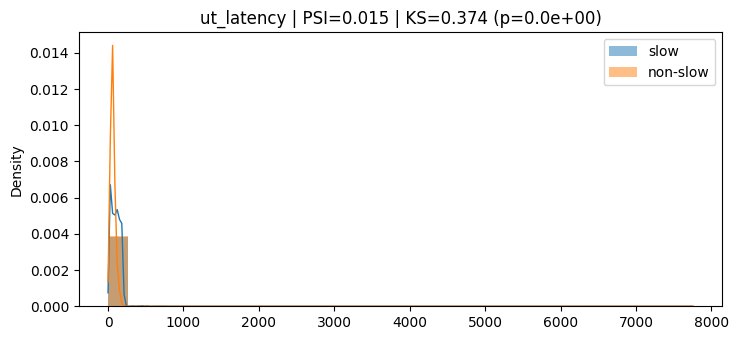

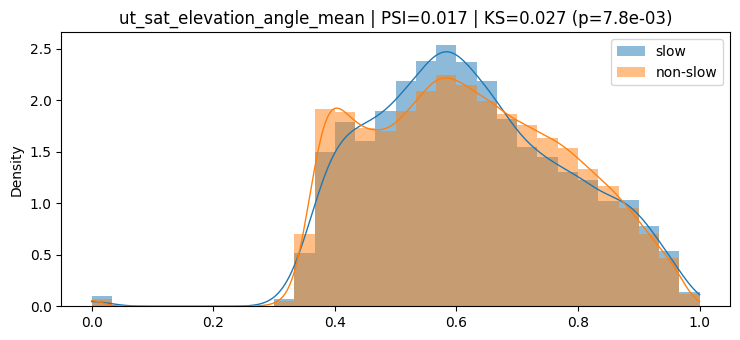

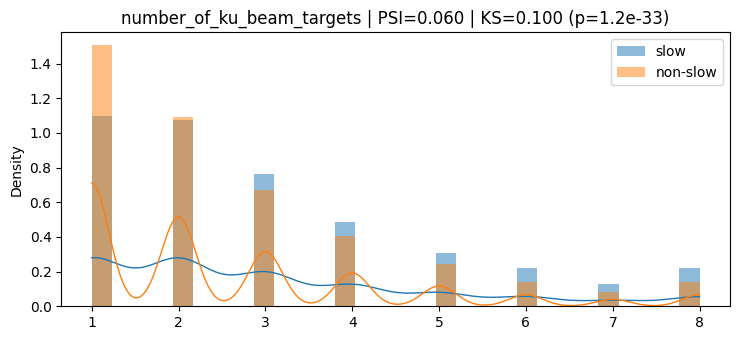

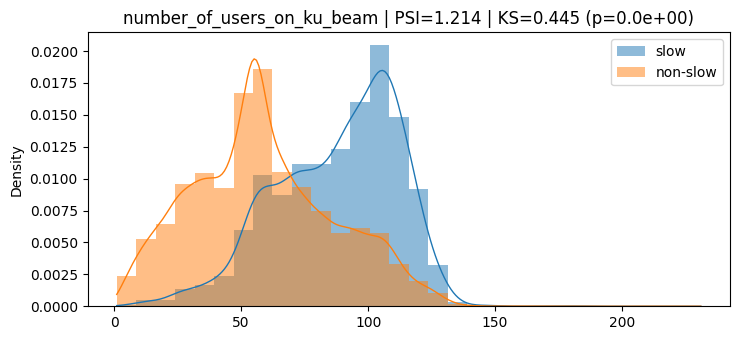

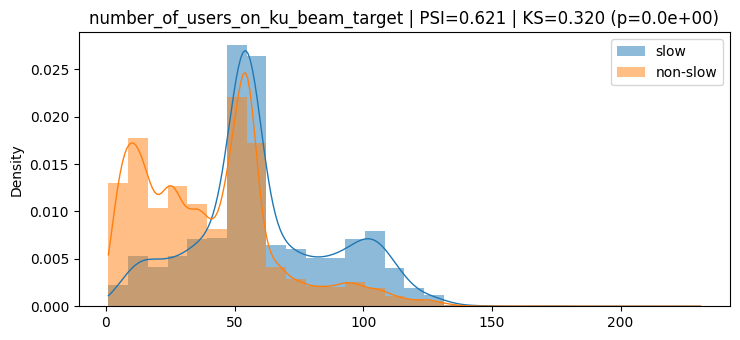

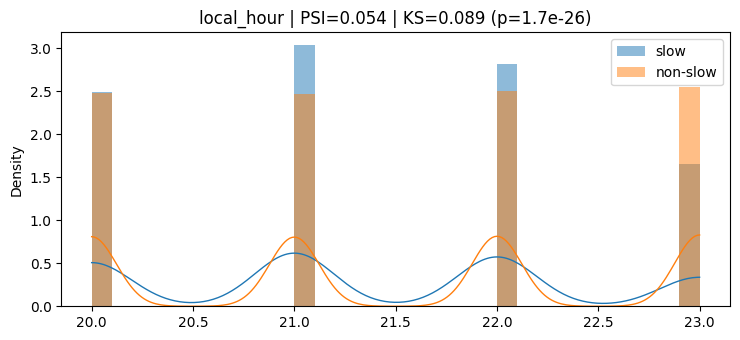

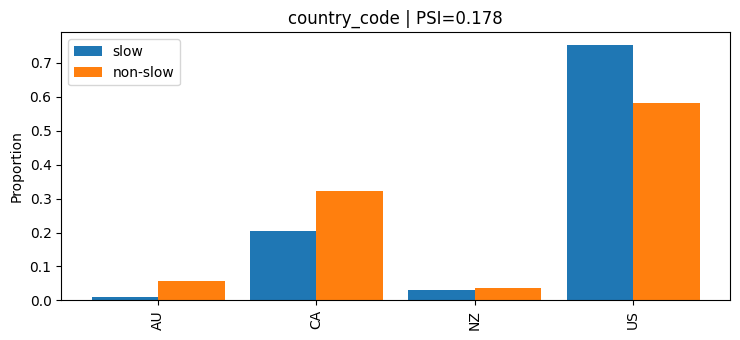

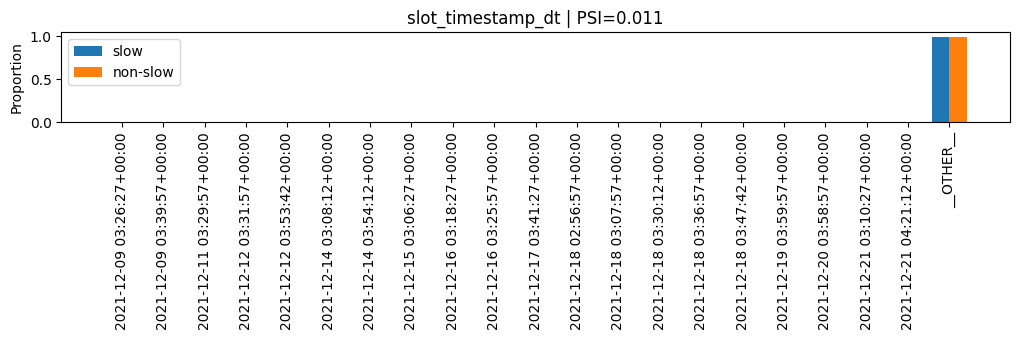

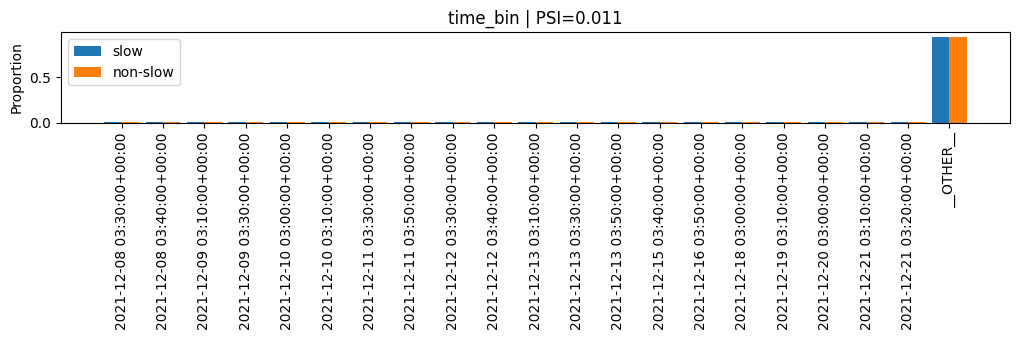

In [9]:
from pandas.api.types import is_numeric_dtype
from scipy.stats import ks_2samp, gaussian_kde

scol = 'router_speedtest_tcp_64_download_Mbps_avg'
features = [
    'slot_timestamp','ut_ping_loss_rate',
    # 'cell_id',
    # 'home_pop_id','gateway_id','satellite_id',
    'ut_snr','expected_min_snr','ut_latency',
    'ut_sat_elevation_angle_mean','number_of_ku_beam_targets','number_of_users_on_ku_beam',
    'number_of_users_on_ku_beam_target',
    # 'ku_beam_target_cell_id',
    'local_hour','country_code','slot_timestamp_dt',
    'time_bin'
]

# Ensure time features exist
if 'slot_timestamp_dt' not in metrics_df.columns:
    _dt = pd.to_datetime(metrics_df['slot_timestamp'], errors='coerce')
    metrics_df['slot_timestamp_dt'] = _dt
    metrics_df['time_bin'] = _dt.dt.floor('10min')

slow = metrics_df[metrics_df[scol] < 50].copy()
non  = metrics_df[metrics_df[scol] >= 50].copy()

eps = 1e-6

def psi_numeric(a, b, max_bins=30):
    s = pd.concat([a, b]).astype(float).dropna().values
    if s.size == 0 or np.unique(s).size < 2:
        return np.nan
    edges = np.histogram_bin_edges(s, bins=min(max_bins, max(5, np.unique(s).size)))
    ha, _ = np.histogram(pd.to_numeric(a, errors='coerce').dropna().values, bins=edges)
    hb, _ = np.histogram(pd.to_numeric(b, errors='coerce').dropna().values, bins=edges)
    pa = ha.astype(float); pb = hb.astype(float)
    pa = np.clip(pa / max(pa.sum(), eps), eps, 1)
    pb = np.clip(pb / max(pb.sum(), eps), eps, 1)
    return float(np.sum((pa - pb) * np.log(pa / pb)))

def psi_categorical(a, b, top=20):
    sa = a.astype('string'); sb = b.astype('string')
    vc = pd.concat([sa, sb]).value_counts()
    keep = set(vc.head(top).index)
    sa = sa.where(sa.isin(keep), '__OTHER__'); sb = sb.where(sb.isin(keep), '__OTHER__')
    cats = list(sorted(set(pd.concat([sa, sb]).dropna().unique())))
    pa = sa.value_counts(normalize=True).reindex(cats, fill_value=0).values
    pb = sb.value_counts(normalize=True).reindex(cats, fill_value=0).values
    pa = np.clip(pa, eps, 1); pb = np.clip(pb, eps, 1)
    pa /= pa.sum(); pb /= pb.sum()
    return float(np.sum((pa - pb) * np.log(pa / pb))), cats, pa, pb

for f in features:
    if f not in metrics_df.columns:
        continue
    a = slow[f].dropna()
    b = non[f].dropna()
    if a.empty or b.empty:
        print(f'{f}: skip (empty a/b)')
        continue

    if is_numeric_dtype(metrics_df[f]):
        av = pd.to_numeric(a, errors='coerce').dropna().values
        bv = pd.to_numeric(b, errors='coerce').dropna().values
        if av.size == 0 or bv.size == 0:
            print(f'{f}: skip (non-numeric after coercion)')
            continue

        psi = psi_numeric(a, b)
        if np.unique(av).size > 1 and np.unique(bv).size > 1:
            ks = ks_2samp(av, bv, alternative='two-sided', mode='auto')
            ks_stat, ks_p = float(ks.statistic), float(ks.pvalue)
        else:
            ks_stat, ks_p = np.nan, np.nan

        edges = np.histogram_bin_edges(np.concatenate([av, bv]), bins=30)
        fig, ax = plt.subplots(figsize=(7.5, 3.5))
        ax.hist(av, bins=edges, density=True, alpha=0.5, label='slow', edgecolor='none')
        ax.hist(bv, bins=edges, density=True, alpha=0.5, label='non-slow', edgecolor='none')

        # Optional KDE if sufficient variability
        try:
            if np.unique(av).size > 1:
                xs = np.linspace(edges[0], edges[-1], 256)
                ax.plot(xs, gaussian_kde(av)(xs), color='C0', linewidth=1)
            if np.unique(bv).size > 1:
                xs = np.linspace(edges[0], edges[-1], 256)
                ax.plot(xs, gaussian_kde(bv)(xs), color='C1', linewidth=1)
        except Exception:
            pass

        ax.set_title(f'{f} | PSI={psi:.3f} | KS={ks_stat if not np.isnan(ks_stat) else np.nan:.3f} (p={ks_p if not np.isnan(ks_p) else np.nan:.1e})')
        ax.legend()
        ax.set_ylabel('Density')
        plt.tight_layout()
        plt.show()

    else:
        psi, cats, pa, pb = psi_categorical(a, b, top=20)
        x = np.arange(len(cats))
        w = 0.42
        fig, ax = plt.subplots(figsize=(max(7.5, 0.3*len(cats)+4), 3.5))
        ax.bar(x - w/2, pa, width=w, label='slow')
        ax.bar(x + w/2, pb, width=w, label='non-slow')
        ax.set_xticks(x)
        ax.set_xticklabels(cats, rotation=90)
        ax.set_ylabel('Proportion')
        ax.set_title(f'{f} | PSI={psi:.3f}')
        ax.legend()
        plt.tight_layout()
        plt.show()

In [10]:
from scipy.stats import pearsonr, pointbiserialr, chi2_contingency
from pandas.api.types import is_numeric_dtype

# Target (binary slow flag) and helper
target_bin = (metrics_df[scol] < 50).astype(int)

def cramers_v_corrected(x, y):
    tbl = pd.crosstab(x, y)
    if tbl.size == 0 or (tbl.values.sum() == 0):
        return np.nan, np.nan, 0
    chi2, p, dof, _ = chi2_contingency(tbl)
    n = tbl.values.sum()
    if n == 0:
        return np.nan, np.nan, dof
    phi2 = chi2 / n
    r, k = tbl.shape
    # Bias correction (Bergsma 2013)
    phi2corr = max(0, phi2 - ((k-1)*(r-1)) / max(n-1, 1))
    rcorr = r - ((r-1)**2) / max(n-1, 1)
    kcorr = k - ((k-1)**2) / max(n-1, 1)
    denom = max(min(kcorr-1, rcorr-1), 1e-12)
    V = np.sqrt(phi2corr / denom)
    return float(V), float(p), dof

# Split features by dtype present
present_feats = [f for f in features if f in metrics_df.columns]
num_feats = [f for f in present_feats if is_numeric_dtype(metrics_df[f])]
cat_feats = [f for f in present_feats if not is_numeric_dtype(metrics_df[f])]

# Numeric vs continuous speed + slow flag (point-biserial)
num_rows = []
for f in num_feats:
    x = pd.to_numeric(metrics_df[f], errors='coerce')
    y = pd.to_numeric(metrics_df[scol], errors='coerce')

    m = x.notna() & y.notna()
    if m.sum() >= 3 and np.unique(x[m]).size > 1 and np.unique(y[m]).size > 1:
        r, p = pearsonr(x[m], y[m])
    else:
        r, p = np.nan, np.nan

    # point-biserial with slow flag (equiv. Pearson with binary)
    m2 = x.notna() & target_bin.notna()
    if m2.sum() >= 3 and np.unique(x[m2]).size > 1 and np.unique(target_bin[m2]).size > 1:
        r_pb, p_pb = pointbiserialr(target_bin[m2], x[m2])
    else:
        r_pb, p_pb = np.nan, np.nan

    num_rows.append({
        'feature': f,
        'n_speed': int(m.sum()),
        'pearson_r_speed': float(r) if pd.notna(r) else np.nan,
        'r2_speed': float(r*r) if pd.notna(r) else np.nan,
        'p_speed': float(p) if pd.notna(p) else np.nan,
        'n_slow': int(m2.sum()),
        'point_biserial_r_slow': float(r_pb) if pd.notna(r_pb) else np.nan,
        'r2_slow': float(r_pb*r_pb) if pd.notna(r_pb) else np.nan,
        'p_slow': float(p_pb) if pd.notna(p_pb) else np.nan,
    })

corr_num = pd.DataFrame(num_rows).sort_values('r2_slow', ascending=False)
display(corr_num.head(25))

# Categorical vs slow flag (Cramér’s V)
cat_rows = []
for f in cat_feats:
    s = metrics_df[f].astype('string')
    tmp = pd.DataFrame({'cat': s, 'slow': target_bin})
    tmp = tmp.dropna()
    # optionally cap very high-cardinality to top categories
    if tmp['cat'].nunique() > 200:
        top = tmp['cat'].value_counts().head(200).index
        tmp['cat'] = tmp['cat'].where(tmp['cat'].isin(top), '__OTHER__')

    if tmp.shape[0] == 0 or tmp['cat'].nunique() < 2:
        V, p, dof = np.nan, np.nan, 0
    else:
        V, p, dof = cramers_v_corrected(tmp['cat'], tmp['slow'])

    cat_rows.append({
        'feature': f,
        'n': int(tmp.shape[0]),
        'n_levels': int(tmp['cat'].nunique()),
        'cramers_v_slow': V,
        'chi2_pval': p,
        'dof': dof,
    })

corr_cat = pd.DataFrame(cat_rows).sort_values('cramers_v_slow', ascending=False)
display(corr_cat.head(25))

# Optional: show top correlations neatly
print("Top numeric by R^2 vs slow flag:")
display(corr_num[['feature','r2_slow','point_biserial_r_slow','p_slow']].head(15))

print("Top categorical by Cramér's V vs slow flag:")
display(corr_cat[['feature','cramers_v_slow','chi2_pval','n_levels','n']].head(15))

,feature,n_speed,pearson_r_speed,r2_speed,p_speed,n_slow,point_biserial_r_slow,r2_slow,p_slow
6,number_of_users_on_ku_beam,68119,-0.471412,0.222230,0.000000e+00,68119,0.239909,5.755631e-02,0.000000e+00
1,ut_snr,68119,0.427582,0.182827,0.000000e+00,68119,-0.213129,4.542400e-02,0.000000e+00
0,ut_ping_loss_rate,67955,-0.242774,0.058939,0.000000e+00,67955,0.199135,3.965465e-02,0.000000e+00
7,number_of_users_on_ku_beam_target,68119,-0.269977,0.072888,0.000000e+00,68119,0.175904,3.094229e-02,0.000000e+00
3,ut_latency,68119,-0.241645,0.058392,0.000000e+00,68119,0.169587,2.875976e-02,0.000000e+00
5,number_of_ku_beam_targets,68119,-0.162611,0.026442,0.000000e+00,68119,0.055602,3.091582e-03,8.679177e-48
8,local_hour,68119,0.062980,0.003966,7.911153e-61,68119,-0.031001,9.610651e-04,5.823598e-16
2,expected_min_snr,68119,0.031773,0.001010,1.089578e-16,68119,-0.010753,1.156165e-04,5.009944e-03
4,ut_sat_elevation_angle_mean,68119,0.021691,0.000471,1.497291e-08,68119,0.000851,7.240420e-07,8.242521e-01


,feature,n,n_levels,cramers_v_slow,chi2_pval,dof
1,country_code,68119,4,0.085998,1.626114e-109,3
3,time_bin,68119,201,0.066308,1.366684e-27,200
0,slot_timestamp,68119,201,0.026777,1.071330e-02,200
2,slot_timestamp_dt,68119,201,0.026777,1.071330e-02,200


Top numeric by R^2 vs slow flag:


,feature,r2_slow,point_biserial_r_slow,p_slow
6,number_of_users_on_ku_beam,5.755631e-02,0.239909,0.000000e+00
1,ut_snr,4.542400e-02,-0.213129,0.000000e+00
0,ut_ping_loss_rate,3.965465e-02,0.199135,0.000000e+00
7,number_of_users_on_ku_beam_target,3.094229e-02,0.175904,0.000000e+00
3,ut_latency,2.875976e-02,0.169587,0.000000e+00
5,number_of_ku_beam_targets,3.091582e-03,0.055602,8.679177e-48
8,local_hour,9.610651e-04,-0.031001,5.823598e-16
2,expected_min_snr,1.156165e-04,-0.010753,5.009944e-03
4,ut_sat_elevation_angle_mean,7.240420e-07,0.000851,8.242521e-01


Top categorical by Cramér's V vs slow flag:


,feature,cramers_v_slow,chi2_pval,n_levels,n
1,country_code,0.085998,1.626114e-109,4,68119
3,time_bin,0.066308,1.366684e-27,201,68119
0,slot_timestamp,0.026777,1.071330e-02,201,68119
2,slot_timestamp_dt,0.026777,1.071330e-02,201,68119


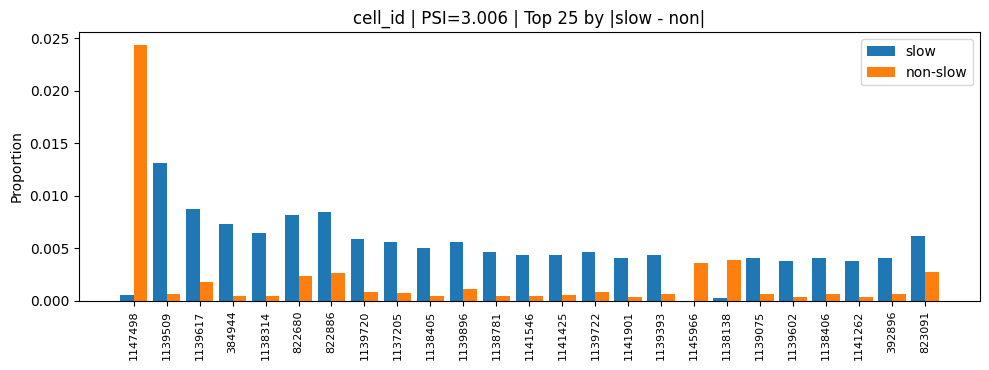

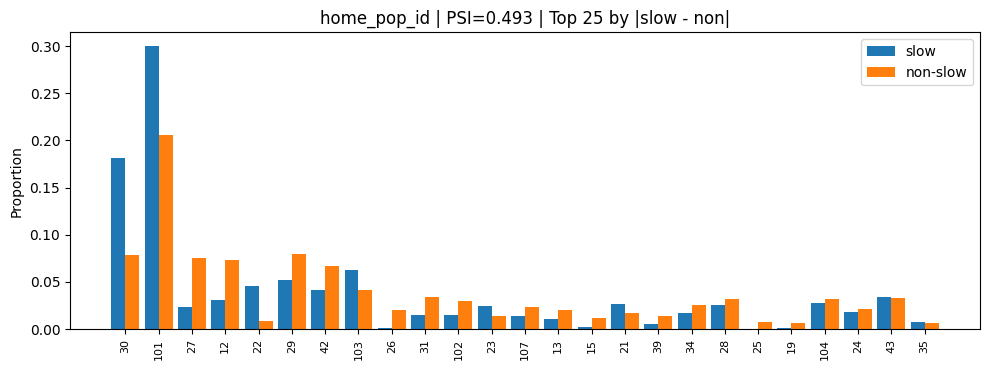

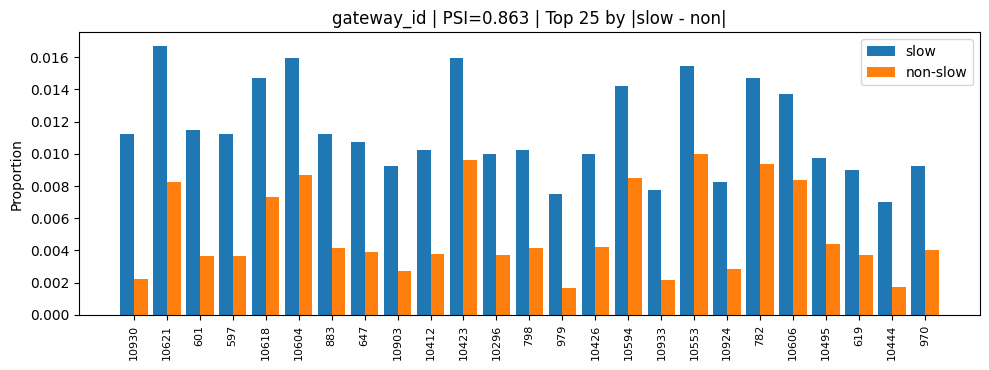

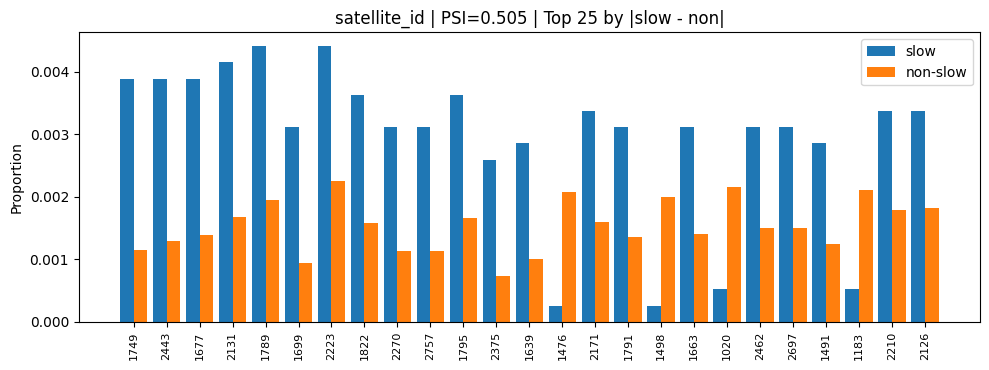

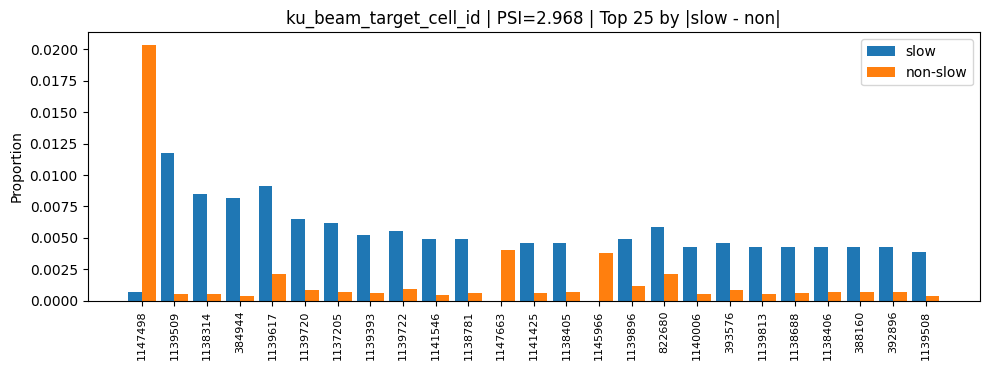

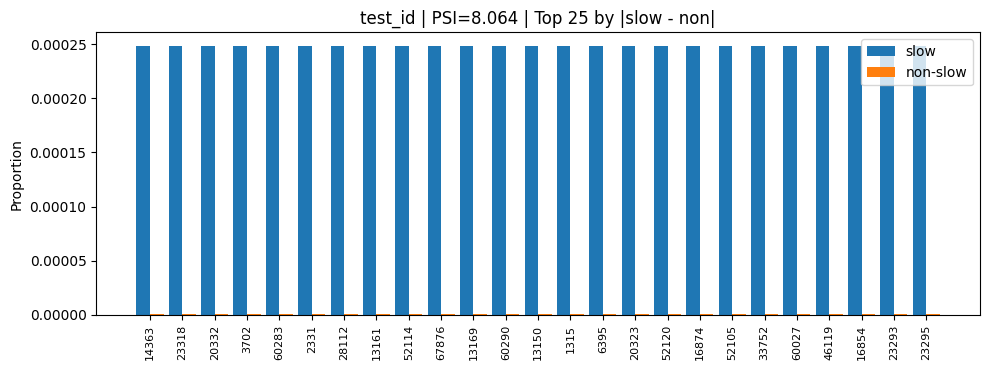

In [11]:
# ...existing code...
# Plot TOP-difference categories for *_id columns (slow vs non-slow)
id_cols = [c for c in metrics_df.columns if c.endswith('_id') or c in ['test_id']]
id_cols = [c for c in id_cols if c in metrics_df.columns]

top_k = 25          # how many categories to show per column
min_total = 20      # require at least this many combined samples across slow+non for a category

eps = 1e-6

for col in id_cols:
    sa = slow[col].astype('string').dropna()
    sb = non[col].astype('string').dropna()
    if sa.empty or sb.empty:
        print(f'{col}: skip (empty a/b)')
        continue

    cats = sorted(set(sa.unique()).union(set(sb.unique())))
    ca = sa.value_counts().reindex(cats, fill_value=0)
    cb = sb.value_counts().reindex(cats, fill_value=0)
    total = ca + cb

    # filter to avoid tiny, noisy categories
    mask = total >= min_total
    if mask.sum() == 0:
        mask = total >= 1  # fallback: keep all if everything is tiny

    cats_f = [c for c, m in zip(cats, mask.values) if m]
    ca = ca[mask]; cb = cb[mask]

    pa = ca.values.astype(float); pb = cb.values.astype(float)
    pa = np.clip(pa / max(pa.sum(), eps), eps, 1)
    pb = np.clip(pb / max(pb.sum(), eps), eps, 1)

    # PSI over filtered cats
    psi = float(np.sum((pa - pb) * np.log(pa / pb)))

    # select by largest absolute difference
    diffs = np.abs(pa - pb)
    order = np.argsort(diffs)[::-1]
    if order.size > top_k:
        order = order[:top_k]

    cats_top = [cats_f[i] for i in order]
    pa_top = pa[order]; pb_top = pb[order]

    x = np.arange(len(cats_top))
    w = 0.42
    fig_w = max(7.5, 0.28*len(cats_top) + 3)
    fig, ax = plt.subplots(figsize=(fig_w, 3.8))
    ax.bar(x - w/2, pa_top, width=w, label='slow')
    ax.bar(x + w/2, pb_top, width=w, label='non-slow')

    ax.set_xticks(x)
    ax.set_xticklabels(cats_top, rotation=90, fontsize=8 if len(cats_top) <= 80 else 6)
    ax.set_ylabel('Proportion')
    ax.set_title(f'{col} | PSI={psi:.3f} | Top {len(cats_top)} by |slow - non|')
    ax.legend()
    plt.tight_layout()
    plt.show()
# ...existing code...

# Predictive Model

In [194]:
# Perform a pd.merge to include gateway information
gateway_df = pd.read_csv("Speed_Test_Interview_Project_Gateways_Table.csv")
print(metrics_df.shape)
print(gateway_df.shape)

df = pd.merge(
    left = metrics_df,
    right = gateway_df,
    how = "left",
    on = ['slot_timestamp', "gateway_id", "satellite_id"],
    indicator = True
    )

df.head()

(68119, 19)
(70319, 9)


,router_speedtest_tcp_64_download_Mbps_avg,slot_timestamp,ut_ping_loss_rate,cell_id,home_pop_id,gateway_id,satellite_id,ut_snr,expected_min_snr,ut_latency,...,local_hour_x,country_code,test_id,gateway_site_id,online_user_count,ka_beam_avg_util_percent,ka_beam_max_util_percent,ka_beam_active_count,local_hour_y,_merge
0,278.145844,2021-12-21T15:26:12Z,0.000000,1050959,12,10158,1288,8.468927,5.640497,62.020656,...,23,AU,1,3019.0,43.0,3.0,20.0,8.0,23.0,both
1,174.016281,2021-12-21T15:06:42Z,0.117603,1051272,13,10053,1238,8.707482,5.358471,81.091325,...,23,AU,2,61.0,100.0,2.0,17.0,8.0,23.0,both
2,249.541458,2021-12-21T15:05:57Z,0.038403,1050955,12,10158,2485,8.867315,6.762557,94.460829,...,23,AU,3,3019.0,54.0,4.0,18.0,8.0,23.0,both
3,222.936905,2021-12-21T14:08:42Z,0.000000,1050962,12,10053,1762,9.449574,6.403923,71.237235,...,22,AU,4,61.0,52.0,3.0,20.0,8.0,22.0,both
4,106.995003,2021-12-21T13:58:27Z,0.000000,835617,13,10375,2474,7.331825,5.267703,36.324433,...,23,AU,5,57.0,919.0,11.0,22.0,8.0,23.0,both


### Handle `local_hour`

In [195]:
# Remove local_hour_x and local_hour_y and replace with local_hour_x. This is because we have UTC timestamps as well as a specific gateway ID 
# associated with the metrics table. We take local_hour_x as the source of truth for local hour.

df = df.drop(columns=['local_hour_y'], errors='ignore') 
df = df.rename(columns={'local_hour_x': 'local_hour'})
df

,router_speedtest_tcp_64_download_Mbps_avg,slot_timestamp,ut_ping_loss_rate,cell_id,home_pop_id,gateway_id,satellite_id,ut_snr,expected_min_snr,ut_latency,...,ku_beam_target_cell_id,local_hour,country_code,test_id,gateway_site_id,online_user_count,ka_beam_avg_util_percent,ka_beam_max_util_percent,ka_beam_active_count,_merge
0,278.145844,2021-12-21T15:26:12Z,0.000000,1050959,12,10158,1288,8.468927,5.640497,62.020656,...,1050645,23,AU,1,3019.0,43.0,3.0,20.0,8.0,both
1,174.016281,2021-12-21T15:06:42Z,0.117603,1051272,13,10053,1238,8.707482,5.358471,81.091325,...,1051588,23,AU,2,61.0,100.0,2.0,17.0,8.0,both
2,249.541458,2021-12-21T15:05:57Z,0.038403,1050955,12,10158,2485,8.867315,6.762557,94.460829,...,1050956,23,AU,3,3019.0,54.0,4.0,18.0,8.0,both
3,222.936905,2021-12-21T14:08:42Z,0.000000,1050962,12,10053,1762,9.449574,6.403923,71.237235,...,1050648,22,AU,4,61.0,52.0,3.0,20.0,8.0,both
4,106.995003,2021-12-21T13:58:27Z,0.000000,835617,13,10375,2474,7.331825,5.267703,36.324433,...,835617,23,AU,5,57.0,919.0,11.0,22.0,8.0,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73256,142.408905,2021-12-08T00:02:12Z,0.000000,377415,27,10443,2476,8.098887,6.736213,55.545372,...,376832,20,CA,68115,NaN,NaN,NaN,NaN,NaN,left_only
73257,291.396881,2021-12-08T00:01:42Z,0.000000,387211,30,568,2517,10.617964,5.603683,32.349100,...,387211,20,CA,68116,NaN,NaN,NaN,NaN,NaN,left_only
73258,98.676376,2021-12-08T00:01:27Z,0.052801,389912,43,10743,1559,4.181670,6.402665,110.407697,...,389581,20,US,68117,NaN,NaN,NaN,NaN,NaN,left_only
73259,250.827438,2021-12-08T00:01:27Z,0.027771,383739,28,10443,2476,8.918145,6.149283,37.836585,...,383115,20,CA,68118,NaN,NaN,NaN,NaN,NaN,left_only


### Handle NaNs that appear in base tables and induced by `pd.merge`

In [196]:
df['_merge'].value_counts()

_merge
both          68358
left_only      4903
right_only        0
Name: count, dtype: int64

In [197]:
df.isna().sum().sort_values(ascending=False)

link_failure_detected                        47363
ka_beam_active_count                          4922
ka_beam_max_util_percent                      4921
ka_beam_avg_util_percent                      4921
online_user_count                             4903
gateway_site_id                               4903
ut_ping_loss_rate                              188
router_speedtest_tcp_64_download_Mbps_avg        0
number_of_users_on_ku_beam_target                0
test_id                                          0
country_code                                     0
local_hour                                       0
ku_beam_target_cell_id                           0
number_of_ku_beam_targets                        0
number_of_users_on_ku_beam                       0
slot_timestamp                                   0
ut_sat_elevation_angle_mean                      0
ut_latency                                       0
expected_min_snr                                 0
ut_snr                         

### Create features & train/test split 

In [198]:
# Obtain all **possible** (emphasize on possible, not final) features
test_input_df = pd.read_csv("test_input.csv")

# Merge with gateway information
test_input_df = pd.merge(
    left = test_input_df,
    right = gateway_df,
    on = ['slot_timestamp', "gateway_id", "satellite_id"],
    how = "left",
    # indicator = True
)

# Address local hour
test_input_df = test_input_df.drop(columns=['local_hour_y'], errors='ignore')
test_input_df = test_input_df.rename(columns={'local_hour_x': 'local_hour'})


test_input_df.head()

,slot_timestamp,ut_ping_loss_rate,cell_id,home_pop_id,gateway_id,satellite_id,ut_snr,expected_min_snr,ut_latency,link_failure_detected,...,ku_beam_target_cell_id,local_hour,country_code,test_id,slow_speed,gateway_site_id,online_user_count,ka_beam_avg_util_percent,ka_beam_max_util_percent,ka_beam_active_count
0,2021-12-21T03:31:42Z,0.000000,1139718,101,10620,2685,8.820867,5.676411,31.474800,False,...,1139718,20,US,70001,NaN,20,1926,39.0,53.0,8.0
1,2021-12-21T03:31:27Z,0.003174,379485,104,10443,1867,9.535334,6.469141,29.762629,False,...,379485,23,US,70002,NaN,18,1212,44.0,64.0,4.0
2,2021-12-21T03:29:42Z,0.006506,391086,101,10536,1193,10.350437,5.745061,41.082993,False,...,391086,21,CA,70003,NaN,519,759,21.0,35.0,8.0
3,2021-12-21T15:33:57Z,0.114278,1051591,12,10034,1955,7.327727,5.593584,79.452012,False,...,1051591,23,AU,70004,NaN,61,110,2.0,14.0,8.0
4,2021-12-21T13:56:27Z,0.006506,841042,12,690,1393,10.529851,5.913839,43.851609,False,...,841043,23,AU,70005,NaN,53,720,9.0,20.0,8.0


In [199]:
# Perform intersection on features from "Speed_Test_Interview_Project_Metrics_Table_v2.csv" analysis above
possible_features = list(set(df.columns.tolist()).intersection(set(test_input_df.columns.tolist())))

# remove test_id
possible_features.remove('test_id')
print(possible_features)

['country_code', 'ut_snr', 'expected_min_snr', 'gateway_id', 'ut_latency', 'online_user_count', 'local_hour', 'slot_timestamp', 'ka_beam_max_util_percent', 'number_of_users_on_ku_beam_target', 'home_pop_id', 'ku_beam_target_cell_id', 'number_of_ku_beam_targets', 'gateway_site_id', 'link_failure_detected', 'number_of_users_on_ku_beam', 'ka_beam_avg_util_percent', 'ut_ping_loss_rate', 'ut_sat_elevation_angle_mean', 'satellite_id', 'ka_beam_active_count', 'cell_id']


In [200]:
# Perform feature engineering to produce the binary target variable. TODO: Also test out a regression model predicting actual speed -> then produce binary from that.

df['slow_speed'] = df['router_speedtest_tcp_64_download_Mbps_avg'] < 50

In [201]:
def dtype_prep(df, target_col=None, possible_features=None):
    """
    Prepares a DataFrame for XGBoost: handles timestamps, booleans, numerics, categoricals.
    If target_col is provided, returns (X, Y). Otherwise, returns X only.
    If possible_features is provided, only those columns are used.
    """
    from pandas.api.types import is_numeric_dtype

    # Use only possible_features if provided
    if possible_features is not None:
        X = df[possible_features].copy()
    else:
        X = df.copy()

    # 1) Timestamps -> numeric features, drop raw string column
    if 'slot_timestamp' in X.columns:
        X['slot_timestamp'] = pd.to_datetime(X['slot_timestamp'], errors='coerce', utc=True)
        X['slot_ts_unix'] = (X['slot_timestamp'].astype('int64') // 10**9).where(X['slot_timestamp'].notna(), np.nan)
        X['slot_hour_utc'] = X['slot_timestamp'].dt.hour
        X['slot_dow'] = X['slot_timestamp'].dt.dayofweek
        X = X.drop(columns=['slot_timestamp'])

    # 2) Coerce boolean-like strings -> bool
    def to_bool_series(s):
        mapping = {'true': True, 'false': False, '1': True, '0': False, 'yes': True, 'no': False}
        low = s.astype(str).str.lower()
        mapped = low.map(mapping)
        if mapped.notna().mean() > 0.95:
            return mapped.fillna(False).astype(bool)
        return None

    for c in list(X.columns):
        if X[c].dtype == 'object':
            b = to_bool_series(X[c])
            if b is not None:
                X[c] = b

    # 3) Numeric coercion (safe)
    for c in list(X.columns):
        if is_numeric_dtype(X[c]):
            X[c] = pd.to_numeric(X[c], errors='coerce')

    # 4) Mark categoricals explicitly
    cat_cols = [c for c in X.columns if c.endswith('_id') or c in ['test_id','cell_id','ku_beam_target_cell_id','country_code']]
    for c in cat_cols:
        if c in X.columns:
            X[c] = X[c].astype('category')

    # 5) Any remaining objects -> category (fallback through string)
    for c in X.columns[X.dtypes == 'object']:
        X[c] = X[c].astype('string').astype('category')


    # 6) Add missingness flags for few high-impact columns
    for c in ["ut_snr","ut_latency","expected_min_snr","number_of_users_on_ku_beam"]:
        if c in df.columns:
            df[f"{c}__isna"] = df[c].isna().astype(int)


    # Final guard: fail early if any object remains
    bad = [c for c, dt in X.dtypes.items() if dt.name == 'object']
    if bad:
        print(f"⚠️ Fixing remaining object dtypes: {bad}")
        for c in bad:
            X[c] = X[c].astype('category')
    bad = [c for c, dt in X.dtypes.items() if dt.name == 'object']
    assert len(bad) == 0, f"Object dtypes still remain: {bad}"

    if target_col is not None and target_col in df.columns:
        Y = df[target_col].astype(bool)
        return X, Y
    else:
        return X


In [202]:
X, Y = dtype_prep(df, target_col='slow_speed', possible_features=possible_features)

from sklearn.model_selection import train_test_split

# Split BEFORE final validation
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Final guard: fail early if any object remains in train set
bad = [c for c, dt in X_train.dtypes.items() if dt.name == 'object']
if bad:
    print(f"⚠️ Fixing remaining object dtypes in train: {bad}")
    for c in bad:
        X_train[c] = X_train[c].astype('category')
        X_test[c] = X_test[c].astype('category')

bad = [c for c, dt in X_train.dtypes.items() if dt.name == 'object']
assert len(bad) == 0, f"Object dtypes still remain: {bad}"

In [203]:
# # Initiate XGBoost Classifier with class imbalance handling
# import xgboost as xgb

# scale_pos_weight = (y_train == 0).sum() / max((y_train == 1).sum(), 1)
# print(f"Scale pos weight (neg/pos): {scale_pos_weight:.2f}")

# model = xgb.XGBClassifier(
#     objective='binary:logistic',
#     eval_metric='aucpr',         
#     n_estimators=2000,            # give trees room
#     max_depth=8,                  # slightly shallower
#     min_child_weight=5,           # stabilize splits
#     subsample=0.8,
#     colsample_bytree=0.8,
#     learning_rate=0.03,           # smaller LR + more trees
#     tree_method='hist',
#     enable_categorical=True,
#     scale_pos_weight= scale_pos_weight,  # handle class imbalance
#     max_delta_step=1,             # helps on imbalanced logistics
#     reg_lambda=1.0, reg_alpha=0.0,
#     random_state=42
# )

# model.early_stopping_rounds = 50

# model.fit(X_train, y_train, verbose=True, eval_set=[(X_test, y_test)])


In [ ]:
# # Initiate XGBoost Classifier with FOCAL LOSS objective (better recall on rare "Slow")
# import numpy as np
# import xgboost as xgb

# def make_focal_loss(alpha: float = 0.25, gamma: float = 2.0):
#     """
#     Binary focal loss for XGBoost.
#     y in {0,1}. predt are raw logits. Uses closed-form grad & hess.

#     L = - [ y * alpha * (1-p)^gamma * log(p) + (1-y) * (1-alpha) * p^gamma * log(1-p) ]
#     where p = sigmoid(logit)
#     """
#     a = float(alpha)
#     b = 1.0 - a
#     g = float(gamma)

#     def fl_obj(predt: np.ndarray, dtrain: xgb.DMatrix):
#         y = dtrain.get_label()
#         # p = sigmoid(logit)
#         p = 1.0 / (1.0 + np.exp(-predt))
#         # numerical safety
#         eps = 1e-9
#         p = np.clip(p, eps, 1.0 - eps)
#         q = 1.0 - p

#         # ---- Gradient dL/dz (z = logit) ----
#         # for y=1: grad1 = a * [ g * p * q^g * log(p) - q^(g+1) ]
#         grad1 = a * (g * p * (q ** g) * np.log(p) - (q ** (g + 1)))
#         # for y=0: grad0 = - b * g * p^g * q * log(q) + b * p^(g+1)
#         grad0 = -b * g * (p ** g) * q * np.log(q) + b * (p ** (g + 1))
#         grad = y * grad1 + (1.0 - y) * grad0

#         # ---- Hessian d^2L/dz^2 ----
#         # for y=1:
#         # hess1 = a * [ g * p * q^g * ( q*log(p) - g*p*log(p) + q ) + (g+1) * p * q^(g+1) ]
#         hess1 = a * (
#             g * p * (q ** g) * (q * np.log(p) - g * p * np.log(p) + q)
#             + (g + 1.0) * p * (q ** (g + 1.0))
#         )
#         # for y=0:
#         # hess0 = - b * g * p^g * q * ( g*q*log(q) - p*log(q) - p ) + b * (g+1) * p^(g+1) * q
#         hess0 = -b * g * (p ** g) * q * (g * q * np.log(q) - p * np.log(q) - p) + b * (g + 1.0) * (p ** (g + 1.0)) * q
#         hess = y * hess1 + (1.0 - y) * hess0

#         # safety: keep hessian positive
#         hess = np.clip(hess, 1e-9, np.inf)
#         return grad, hess

#     return fl_obj

# # Choose focal-loss hyperparams (tune if needed)
# FOCAL_ALPHA = 0.75   # weight on positives (increase for higher recall on minority)
# FOCAL_GAMMA = 2.0    # focusing parameter (higher => focus more on hard examples)

# print(f"Using FOCAL LOSS with alpha={FOCAL_ALPHA}, gamma={FOCAL_GAMMA}")

# model = xgb.XGBClassifier(
#     # objective will be provided via custom obj, keep a placeholder
#     objective='binary:logistic',
#     eval_metric='aucpr',          # optimize for PR curve given imbalance
#     n_estimators=2000,
#     max_depth=5,
#     min_child_weight=5,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     learning_rate=0.01,
#     tree_method='hist',
#     enable_categorical=True,
#     scale_pos_weight=1.0,         # DON'T double-count; focal alpha handles class skew
#     max_delta_step=1,
#     reg_lambda=1.0,
#     reg_alpha=0.0,
#     random_state=42
# )

# model.early_stopping_rounds = 50

# # Train with custom focal-loss objective
# focal_obj = make_focal_loss(alpha=FOCAL_ALPHA, gamma=FOCAL_GAMMA)
# model.obj = focal_obj
# model.fit(
#     X_train, y_train,
#     verbose=True,
#     eval_set=[(X_test, y_test)],
#     # obj=focal_obj
# )


Using FOCAL LOSS with alpha=0.75, gamma=2.0
[0]	validation_0-aucpr:0.18053
[1]	validation_0-aucpr:0.18905
[2]	validation_0-aucpr:0.21256
[3]	validation_0-aucpr:0.21555
[4]	validation_0-aucpr:0.21899
[5]	validation_0-aucpr:0.29350
[6]	validation_0-aucpr:0.29189
[7]	validation_0-aucpr:0.30160
[8]	validation_0-aucpr:0.30568
[9]	validation_0-aucpr:0.30552
[10]	validation_0-aucpr:0.32309
[11]	validation_0-aucpr:0.32340
[12]	validation_0-aucpr:0.33892
[13]	validation_0-aucpr:0.33768
[14]	validation_0-aucpr:0.34084
[15]	validation_0-aucpr:0.34137
[16]	validation_0-aucpr:0.34817
[17]	validation_0-aucpr:0.34966
[18]	validation_0-aucpr:0.35043
[19]	validation_0-aucpr:0.36062
[20]	validation_0-aucpr:0.36259
[21]	validation_0-aucpr:0.36385
[22]	validation_0-aucpr:0.36395
[23]	validation_0-aucpr:0.36818
[24]	validation_0-aucpr:0.36812
[25]	validation_0-aucpr:0.36785
[26]	validation_0-aucpr:0.36750
[27]	validation_0-aucpr:0.36975
[28]	validation_0-aucpr:0.36911
[29]	validation_0-aucpr:0.36879
[30]	v

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,50
,enable_categorical,True
,eval_metric,'aucpr'


LightGBM scale_pos_weight base=15.91 using=31.82
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 3466, number of negative: 55142
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001943 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12748
[LightGBM] [Info] Number of data points in the train set: 58608, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.059139 -> initscore=-2.766910
[LightGBM] [Info] Start training from score -2.766910

Chosen threshold: 0.5000
PR-AUC (Average Precision): 0.5604
ROC-AUC: 0.9153

Confusion matrix @ tuned threshold:
[[13577   196]
 [  526   354]]

Classification report @ tuned threshold:
              precision    recall  f1-s

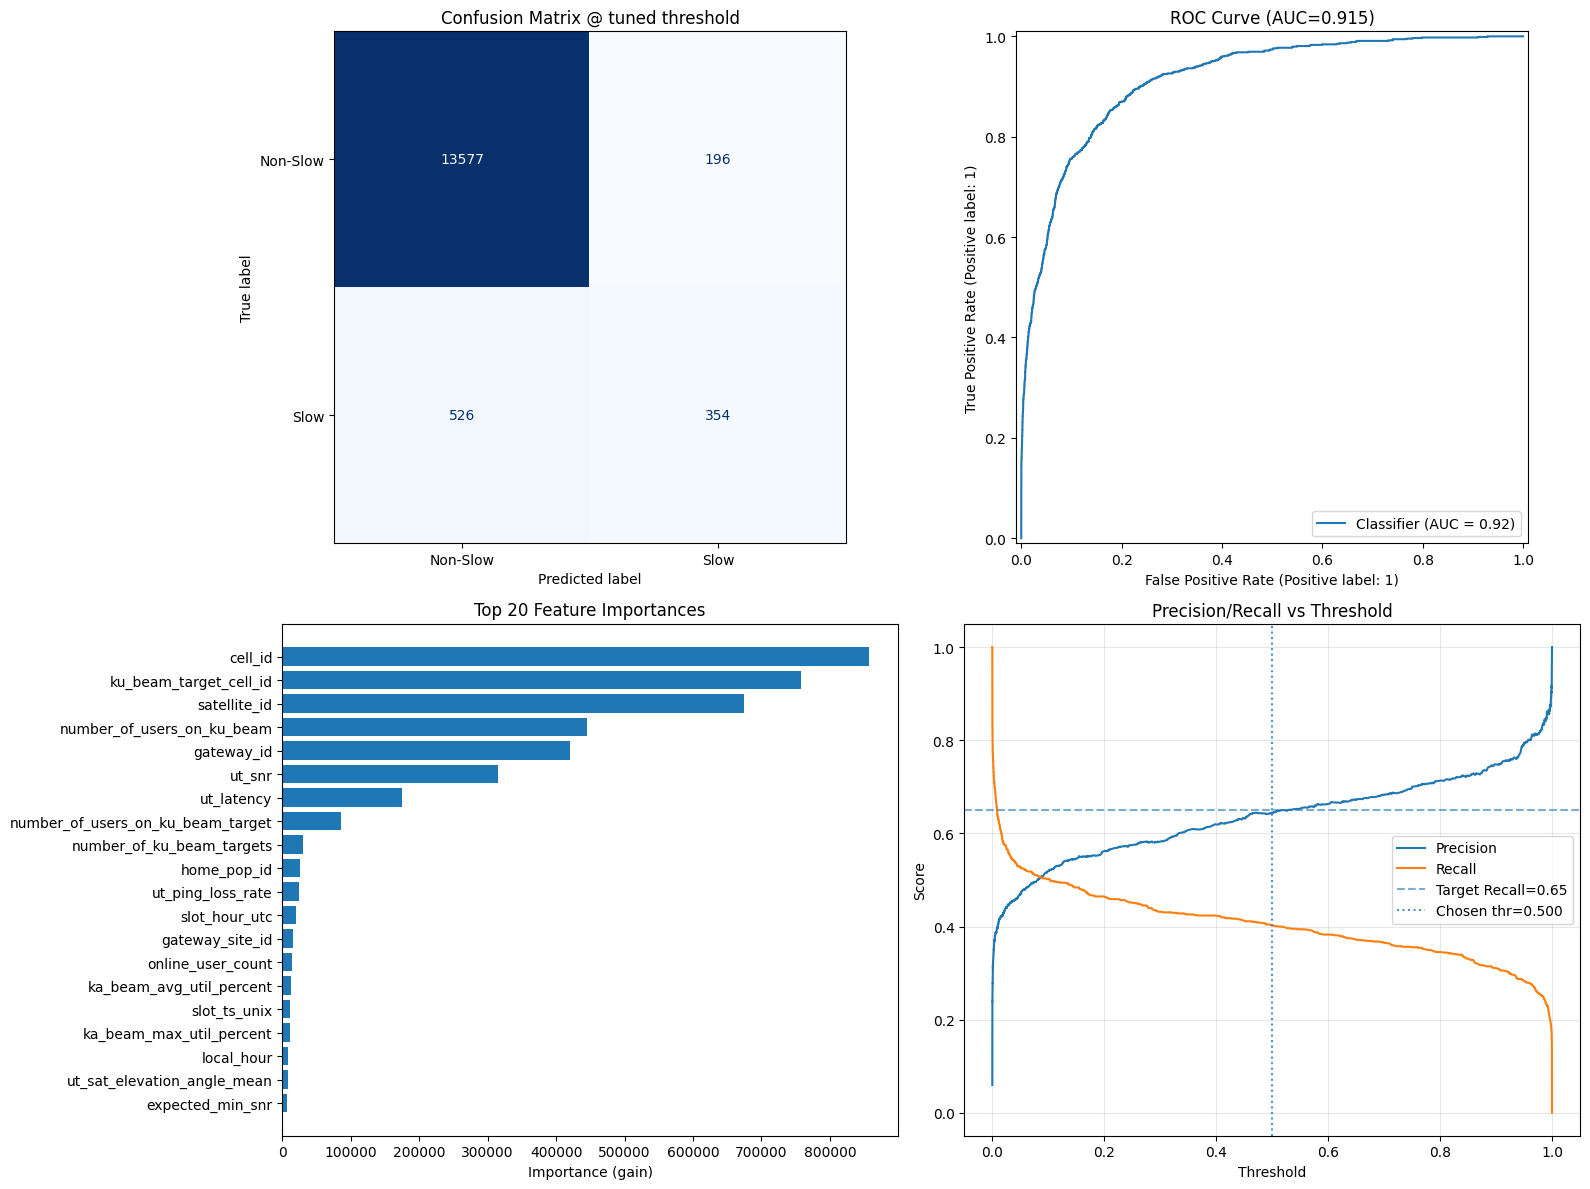

In [210]:
# ============================================================
#   LIGHTGBM BASELINE + CLASS WEIGHT + AUC-PR + THRESHOLD TUNE
#   (drop-in replacement for the focal-loss XGBoost cell)
# ============================================================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    precision_recall_curve, average_precision_score, roc_auc_score,
    classification_report, confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay
)
import lightgbm as lgb

# ---- Detect categorical columns (must be pandas 'category') ----
cat_cols = [c for c in X_train.columns if str(X_train[c].dtype) == 'category']
# Make sure test has identical dtype for those columns
for c in cat_cols:
    if str(X_test[c].dtype) != 'category':
        X_test[c] = X_test[c].astype('category')

# ---- Stronger class weighting (try 1.5×–3× base neg/pos) ----
base_spw = (y_train == 0).sum() / max((y_train == 1).sum(), 1)
scale_pos_weight = base_spw * 2.0
print(f"LightGBM scale_pos_weight base={base_spw:.2f} using={scale_pos_weight:.2f}")

# ---- Model ----
# Notes:
# - 'average_precision' is PR-AUC; we also track 'auc'
# - use early stopping on the eval set
# - LightGBM uses 'num_leaves' to control complexity; ~2^(max_depth) is a rough mapping
lgbm = lgb.LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    n_estimators=5000,
    learning_rate=0.02,
    num_leaves=63,            # ~depth≈6
    min_child_samples=40,     # similar to min_child_weight notion
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.0,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs = -1
)

lgbm.early_stopping_rounds = 200

lgbm.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric=['average_precision','auc'],
    categorical_feature=cat_cols,
    # early_stopping_rounds=200,
    # verbose=True
)

# ---- Predictions & metrics ----
proba = lgbm.predict_proba(X_test, raw_score=False)[:, 1]
ap   = average_precision_score(y_test, proba)   # PR-AUC
roc  = roc_auc_score(y_test, proba)

# ---- Threshold tuning: pick smallest threshold achieving target recall ----
target_recall = 0.65
prec, rec, thr = precision_recall_curve(y_test, proba)
# thresholds length = len(prec)-1
idx = next((i for i, r in enumerate(rec) if r >= target_recall), None)
if idx is None or idx == 0:
    chosen_thr = 0.5
else:
    chosen_thr = thr[idx-1]

y_hat = (proba >= chosen_thr).astype(int)

print(f"\nChosen threshold: {chosen_thr:.4f}")
print(f"PR-AUC (Average Precision): {ap:.4f}")
print(f"ROC-AUC: {roc:.4f}")
print("\nConfusion matrix @ tuned threshold:")
print(confusion_matrix(y_test, y_hat))
print("\nClassification report @ tuned threshold:")
print(classification_report(y_test, y_hat, target_names=['Non-Slow','Slow']))

# ---- Plots: CM, ROC, PR-vs-threshold, Feature importances ----
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# 1) Confusion Matrix
cm = confusion_matrix(y_test, y_hat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Slow', 'Slow'])
disp.plot(ax=axs[0, 0], cmap='Blues', values_format='d', colorbar=False)
axs[0, 0].set_title('Confusion Matrix @ tuned threshold')

# 2) ROC Curve
RocCurveDisplay.from_predictions(y_test, proba, ax=axs[0, 1])
axs[0, 1].set_title(f'ROC Curve (AUC={roc:.3f})')

# 3) Precision/Recall vs Threshold
axs[1, 1].plot(thr, prec[:-1], label='Precision')
axs[1, 1].plot(thr, rec[:-1], label='Recall')
axs[1, 1].axhline(y=target_recall, linestyle='--', alpha=0.6, label=f'Target Recall={target_recall:.2f}')
axs[1, 1].axvline(x=chosen_thr, linestyle=':', alpha=0.8, label=f'Chosen thr={chosen_thr:.3f}')
axs[1, 1].set_xlabel('Threshold')
axs[1, 1].set_ylabel('Score')
axs[1, 1].set_title('Precision/Recall vs Threshold')
axs[1, 1].legend()
axs[1, 1].grid(True, alpha=0.3)

# 4) Feature importances (gain)
importances = lgbm.booster_.feature_importance(importance_type='gain')
feat_names = lgbm.booster_.feature_name()
idxs = np.argsort(importances)[::-1][:20]
axs[1, 0].barh(range(len(idxs)), importances[idxs])
axs[1, 0].set_yticks(range(len(idxs)))
axs[1, 0].set_yticklabels([feat_names[i] for i in idxs])
axs[1, 0].invert_yaxis()
axs[1, 0].set_xlabel('Importance (gain)')
axs[1, 0].set_title('Top 20 Feature Importances')

plt.tight_layout()
plt.show()


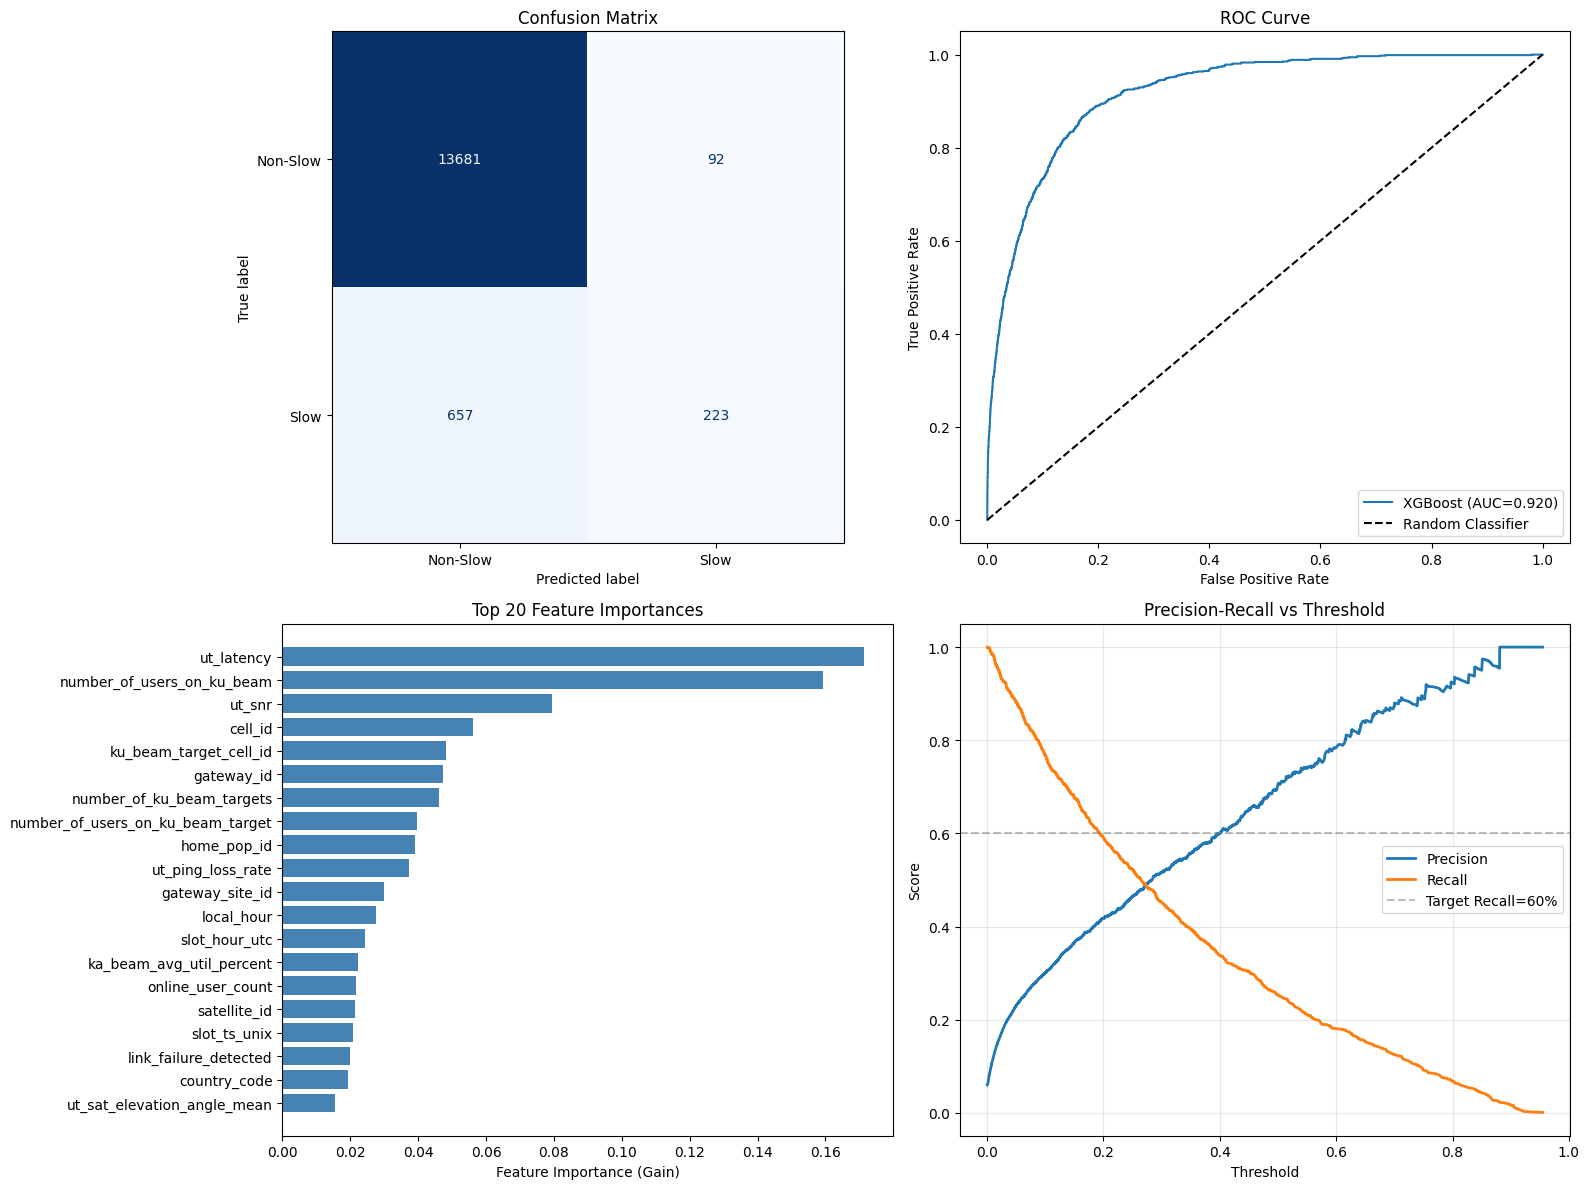

CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Non-Slow       0.95      0.99      0.97     13773
        Slow       0.71      0.25      0.37       880

    accuracy                           0.95     14653
   macro avg       0.83      0.62      0.67     14653
weighted avg       0.94      0.95      0.94     14653


ROC-AUC Score: 0.9196

MODEL SUMMARY
Total test samples: 14653
Actual slow speeds: 880 (6.01%)
Predicted slow speeds: 315 (2.15%)
Accuracy: 0.9489
ROC-AUC: 0.9196


In [205]:
# Now evaluate model performance
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay, precision_recall_curve

# Generate predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Prepare confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Prepare ROC curve data
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Prepare feature importance
importances = model.feature_importances_
indices = np.argsort(importances)[::-1][:20]  # Top 20 features
feature_names = X_train.columns

# Prepare precision-recall curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Create a 2x2 grid of plots
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Slow', 'Slow'])
disp.plot(ax=axs[0, 0], cmap='Blues', values_format='d', colorbar=False)
axs[0, 0].set_title('Confusion Matrix')

# ROC Curve
axs[0, 1].plot(fpr, tpr, label=f'XGBoost (AUC={roc_auc:.3f})')
axs[0, 1].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
axs[0, 1].set_title('ROC Curve')
axs[0, 1].set_xlabel('False Positive Rate')
axs[0, 1].set_ylabel('True Positive Rate')
axs[0, 1].legend()

# Feature Importance
axs[1, 0].barh(range(len(indices)), importances[indices], color='steelblue')
axs[1, 0].set_yticks(range(len(indices)))
axs[1, 0].set_yticklabels([feature_names[i] for i in indices])
axs[1, 0].set_xlabel('Feature Importance (Gain)')
axs[1, 0].set_title('Top 20 Feature Importances')
axs[1, 0].invert_yaxis()

# Precision-Recall vs Threshold
axs[1, 1].plot(thresholds, precisions[:-1], label='Precision', linewidth=2)
axs[1, 1].plot(thresholds, recalls[:-1], label='Recall', linewidth=2)
axs[1, 1].axhline(y=0.60, color='gray', linestyle='--', alpha=0.5, label='Target Recall=60%')
axs[1, 1].set_xlabel('Threshold')
axs[1, 1].set_ylabel('Score')
axs[1, 1].set_title('Precision-Recall vs Threshold')
axs[1, 1].legend()
axs[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print reports and summary
print("=" * 60)
print("CLASSIFICATION REPORT")
print("=" * 60)
print(classification_report(y_test, y_pred, target_names=['Non-Slow', 'Slow']))

print(f"\n{bcolors.OKGREEN}ROC-AUC Score: {roc_auc:.4f}{bcolors.ENDC}\n")

print("=" * 60)
print("MODEL SUMMARY")
print("=" * 60)
print(f"Total test samples: {len(y_test)}")
print(f"Actual slow speeds: {y_test.sum()} ({100*y_test.mean():.2f}%)")
print(f"Predicted slow speeds: {y_pred.sum()} ({100*y_pred.mean():.2f}%)")
print(f"Accuracy: {(y_pred == y_test).mean():.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print("=" * 60)

In [ ]:
# Fantastic but we should do this again to address class imbalance

# Observe class imbalance
df['slow_speed'].value_counts(normalize=False)

slow_speed
False    68915
True      4346
Name: count, dtype: int64

In [124]:
# Prepare test_input_df for prediction using the same dtype_prep logic and possible_features
# Ensure 'slow_speed' is NOT in the features for prediction

# Remove 'slow_speed' if present in test_input_df
# test_input_df = test_input_df.drop(columns=['slow_speed'], errors='ignore')

# Prepare X_actual with the same feature order as training
X_actual = dtype_prep(test_input_df, possible_features=possible_features)

# Ensure columns are in the same order as model was trained on
X_actual = X_actual[X_train.columns]

# Now you can safely predict
y_pred_actual = model.predict(X_actual)
y_pred_proba_actual = model.predict_proba(X_actual)

# Example: show predictions
print("Predicted probabilities for test_input_df:")
print(y_pred_proba_actual)

Predicted probabilities for test_input_df:
[[9.9138659e-01 8.6133974e-03]
 [9.9733150e-01 2.6685225e-03]
 [9.9946827e-01 5.3175364e-04]
 [9.9955040e-01 4.4962094e-04]
 [9.9970800e-01 2.9198881e-04]
 [9.9958307e-01 4.1692806e-04]
 [9.9871659e-01 1.2834008e-03]]
